# Predicción y Evaluación del Modelo

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv("data/compartamosFiltrado.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29728 entries, 0 to 29727
Data columns (total 14 columns):
codigoCredito       29728 non-null int64
codigoOficina       29728 non-null int64
tipoCredito         29728 non-null object
sector              29728 non-null object
destinoCredito      29728 non-null object
fechaAperturaMin    29728 non-null object
fechaAperturaMax    29728 non-null object
montoApertura       29728 non-null float64
numeroCuotas        29728 non-null int64
interes             29728 non-null float64
condicionCredito    29728 non-null object
esDeudor            29728 non-null int64
cuentaUnica         29728 non-null int64
periodos            29728 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 3.2+ MB


__Configuramos los parámetros de Entrada y salida__

In [2]:
dummy_codigoOficina = pd.get_dummies(df.codigoOficina, prefix="of", drop_first=True)
dummy_tipoCredito = pd.get_dummies(df.tipoCredito, drop_first=True)
dummy_sector = pd.get_dummies(df.sector, drop_first=True)
dummy_destinoCredito = pd.get_dummies(df.destinoCredito, drop_first=True)
dummy_condicionCredito = pd.get_dummies(df.condicionCredito, drop_first=True)
dummy_periodos = pd.get_dummies(df.periodos, drop_first=True)

X = pd.concat([dummy_codigoOficina, dummy_tipoCredito, dummy_sector, dummy_destinoCredito, dummy_condicionCredito, dummy_periodos,
               df[['cuentaUnica', 'interes', 'montoApertura', 'numeroCuotas']]], axis=1)
y = df.esDeudor
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29728 entries, 0 to 29727
Data columns (total 30 columns):
of_5               29728 non-null uint8
of_7               29728 non-null uint8
of_8               29728 non-null uint8
of_12              29728 non-null uint8
of_18              29728 non-null uint8
of_35              29728 non-null uint8
of_36              29728 non-null uint8
of_38              29728 non-null uint8
RECUPERADO         29728 non-null uint8
RECURRENTE         29728 non-null uint8
MICROEMPRESA       29728 non-null uint8
PYMES              29728 non-null uint8
AFINFORMAL         29728 non-null uint8
CONSUMO            29728 non-null uint8
CTFORMAL           29728 non-null uint8
CTINFORMAL         29728 non-null uint8
JUDICIAL           29728 non-null uint8
NORMAL             29728 non-null uint8
VENCIDO            29728 non-null uint8
VENCIDO+120DIAS    29728 non-null uint8
sem2               29728 non-null uint8
sem3               29728 non-null uint8
sem4       

__Dividimos la Data aleatoriamente en 80% para entrenar y 20% para evaluar__

In [3]:
seed = 100
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

__Testing Classifiers__

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score # binary
from sklearn.metrics import auc

from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold


scoring_acc = ['precision', 'precision_weighted', 'roc_auc', 'accuracy']

listaModelos = [
    LogisticRegression(),
    KNeighborsClassifier(n_jobs=-1),
    DecisionTreeClassifier(random_state=seed),
    RandomForestClassifier(n_jobs=-1, random_state=seed)
]
kf = KFold(n_splits=10)

resultados = {}
predictTest = {}
for modelClassifier in listaModelos:
    modelName = str(modelClassifier).split("(")[0]
    modelClassifier.fit(X_train, y_train)
    modelResult = cross_validate(modelClassifier, X_train, y_train, scoring=scoring_acc, cv=kf, return_train_score=False)
    print(modelName)
    print('accuracy:\t\t ' + str(modelResult['test_accuracy'].mean()) + ' +/- ' + str(modelResult['test_accuracy'].std()))
    print('precision_weighted:\t ' + str(modelResult['test_precision_weighted'].mean()) + ' +/- ' + str(modelResult['test_precision_weighted'].std()))
    print('precision:\t\t ' + str(modelResult['test_precision'].mean()) + ' +/- ' + str(modelResult['test_precision'].std()))
    print('roc_auc:\t\t ' + str(modelResult['test_roc_auc'].mean()) + ' +/- ' + str(modelResult['test_roc_auc'].std()))
    print('-----------------')
    resultados[modelName] = modelResult
    predictTest[modelName] = modelClassifier.predict(X_test)

LogisticRegression
accuracy:		 0.8896649651368452 +/- 0.006054988455625454
precision_weighted:	 0.9026027904594095 +/- 0.004424113898349163
precision:		 0.9952209152940872 +/- 0.0030187321200950386
roc_auc:		 0.774771397686594 +/- 0.00951408109007795
-----------------
KNeighborsClassifier
accuracy:		 0.7940047500009721 +/- 0.007834839240486951
precision_weighted:	 0.7631475746572256 +/- 0.009613315625323464
precision:		 0.5376079408938941 +/- 0.028446005532604932
roc_auc:		 0.6740426997730866 +/- 0.011215317338234979
-----------------
DecisionTreeClassifier
accuracy:		 0.809393961248392 +/- 0.0063293723907345
precision_weighted:	 0.813727767087198 +/- 0.007372671527980598
precision:		 0.5516892972674566 +/- 0.01791663064521613
roc_auc:		 0.7273938478509792 +/- 0.010226089550410888
-----------------
RandomForestClassifier
accuracy:		 0.8623336518619784 +/- 0.007107746531057857
precision_weighted:	 0.8542643297699181 +/- 0.007973489787587103
precision:		 0.7522019317017389 +/- 0.02089769

In [5]:
dfG =  pd.DataFrame(columns=['score', 'model', 'type']) 
for modelClassifier in listaModelos:
    modelName = str(modelClassifier).split("(")[0]
    dfG1 = pd.DataFrame(resultados[modelName]['test_accuracy'], columns=['score']) 
    dfG1['model'] = modelName
    dfG1['type'] = 'accuracy'
    dfG2 = pd.DataFrame(resultados[modelName]['test_roc_auc'], columns=['score']) 
    dfG2['model'] = modelName
    dfG2['type'] = 'auc'
    dfG = pd.concat([dfG, dfG1, dfG2], axis=0)

means = dfG.groupby(['model', 'type'])['score'].mean()
means

model                   type    
DecisionTreeClassifier  accuracy    0.809394
                        auc         0.727394
KNeighborsClassifier    accuracy    0.794005
                        auc         0.674043
LogisticRegression      accuracy    0.889665
                        auc         0.774771
RandomForestClassifier  accuracy    0.862334
                        auc         0.771110
Name: score, dtype: float64

<IPython.core.display.Javascript object>


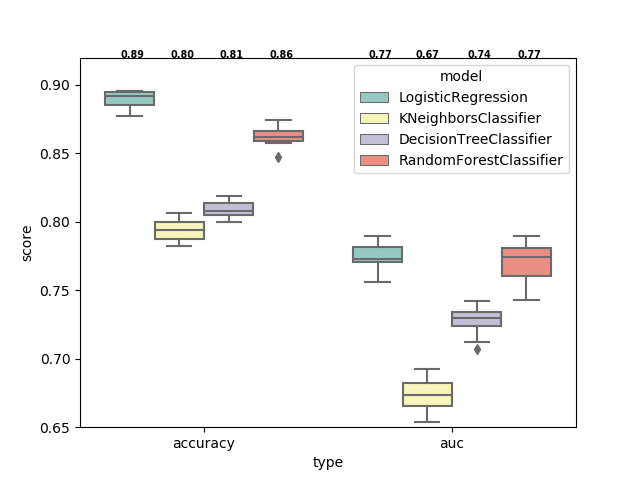

Text(1.36,0.92,'0.77')

In [12]:
%matplotlib notebook
ax = sns.boxplot(x="type", y="score", hue="model", data=dfG, palette="Set3")
tope =  0.92
ax.axes.set_ylim(0.65, tope)
pos = ax.get_xticklabels(which='both')
ax.text(-0.24, tope, "0.89", horizontalalignment='right', size='x-small', color='black', weight='semibold')
ax.text(-0.04, tope, "0.80", horizontalalignment='right', size='x-small', color='black', weight='semibold')
ax.text(0.16, tope, "0.81", horizontalalignment='right', size='x-small', color='black', weight='semibold')
ax.text(0.36, tope, "0.86", horizontalalignment='right', size='x-small', color='black', weight='semibold')
ax.text(0.76, tope, "0.77", horizontalalignment='right', size='x-small', color='black', weight='semibold')
ax.text(0.95, tope, "0.67", horizontalalignment='right', size='x-small', color='black', weight='semibold')
ax.text(1.16, tope, "0.74", horizontalalignment='right', size='x-small', color='black', weight='semibold')
ax.text(1.36, tope, "0.77", horizontalalignment='right', size='x-small', color='black', weight='semibold')

## Trabajando con nuevos datos

In [21]:
import sys
import itertools
sys.path.append("./lib/")
from lib.FuncionesGenerales import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

cfLor = confusion_matrix(y_test, predictTest['LogisticRegression'])
cfKnn = confusion_matrix(y_test, predictTest['KNeighborsClassifier'])
cfDt = confusion_matrix(y_test, predictTest['DecisionTreeClassifier'])
cfRf = confusion_matrix(y_test, predictTest['RandomForestClassifier'])

print('Accuracy de LogisticRegression: ' + str(cfLor.diagonal().sum()/y_test.count()))
print('Accuracy de KNeighborsClassifier: ' + str(cfDt.diagonal().sum()/y_test.count()))
print('Accuracy de DecisionTreeClassifier: ' + str(cfKnn.diagonal().sum()/y_test.count()))
print('Accuracy de RandomForestClassifier: ' + str(cfRf.diagonal().sum()/y_test.count()))

Precisión de LogisticRegression: 0.8905146316851665
Precisión de KNeighborsClassifier: 0.817188025563404
Precisión de DecisionTreeClassifier: 0.7938109653548604
Precisión de RandomForestClassifier: 0.8666330306088127


__Evaluando la Accuracy__

<IPython.core.display.Javascript object>


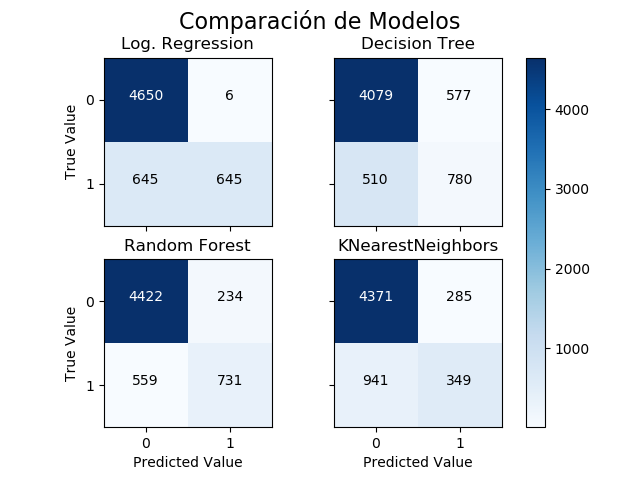

In [11]:

classes = y.unique()
fig, axs = plt.subplots(2, 2, sharey=True, sharex=True)

gcolor = axs[0][0].imshow(cfLor, interpolation='nearest', cmap=plt.cm.Blues)
axs[1][0].imshow(cfDt, interpolation='nearest', cmap=plt.cm.Blues)
axs[0][1].imshow(cfKnn, interpolation='nearest', cmap=plt.cm.Blues)
axs[1][1].imshow(cfRf, interpolation='nearest', cmap=plt.cm.Blues)


cList = [cfLor, cfDt, cfRf, cfKnn]
cNameList = ['Log. Regression', 'Decision Tree', 'Random Forest', 'KNearestNeighbors']

for k in range(4):
    cm = cList[k]
    axs[np.int(k/2)][k%2].set_title(cNameList[k])
    axs[np.int(k/2)][k%2].set_xticks(classes)
    axs[np.int(k/2)][k%2].set_yticks(classes)
    axs[np.int(k/2)][0].set_ylabel('True Value')
    axs[1][k%2].set_xlabel('Predicted Value')
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axs[np.int(k/2)][k%2].text(j, i, format(cm[i, j], 'd'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")


fig.suptitle('Comparación de Modelos', fontsize=16)
fig.colorbar(gcolor, ax=axs, fraction=.1)

In [34]:
y_test.value_counts()

0    4656
1    1290
Name: esDeudor, dtype: int64

__Se observa que:__ El modelo de _Regresión Logística_ predice con mayor certeza a los créditos que si serán cancelados (sin deuda), mientras que el _Árbol de Decisión_ identifica mejor a los créditos que no serán cancelados (deuda).

__Indicadores de Calidad:__ Si definimos como TP: Los créditos que No serán pagados y como TN: Los créditos que si serán pagados, tenemos (0:TN y 1:TP):

In [35]:
display('SENSIBILIDAD')
print('Sensibilidad de LogisticRegression: ' + str(cfLor[1][1]/(cfLor[1][1]+cfLor[1][0])))
print('Sensibilidad de KNeighborsClassifier: ' + str(cfDt[1][1]/(cfDt[1][1]+cfDt[1][0])))
print('Sensibilidad de DecisionTreeClassifier: ' + str(cfKnn[1][1]/(cfKnn[1][1]+cfKnn[1][0])))
print('Sensibilidad de RandomForestClassifier: ' + str(cfRf[1][1]/(cfRf[1][1]+cfRf[1][0])))

display('ESPECIFIDAD')
print('Especifidad de LogisticRegression: ' + str(cfLor[0][0]/(cfLor[0][0]+cfLor[0][1])))
print('Especifidad de KNeighborsClassifier: ' + str(cfDt[0][0]/(cfDt[0][0]+cfDt[0][1])))
print('Especifidad de DecisionTreeClassifier: ' + str(cfKnn[0][0]/(cfKnn[0][0]+cfKnn[0][1])))
print('Especifidad de RandomForestClassifier: ' + str(cfRf[0][0]/(cfRf[0][0]+cfRf[0][1])))

'SENSIBILIDAD'

Sensibilidad de LogisticRegression: 0.5
Sensibilidad de KNeighborsClassifier: 0.6046511627906976
Sensibilidad de DecisionTreeClassifier: 0.27054263565891473
Sensibilidad de RandomForestClassifier: 0.5666666666666667


'ESPECIFIDAD'

Especifidad de LogisticRegression: 0.9987113402061856
Especifidad de KNeighborsClassifier: 0.876073883161512
Especifidad de DecisionTreeClassifier: 0.9387886597938144
Especifidad de RandomForestClassifier: 0.9497422680412371
